In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from fastai import *
from fastai.text import *

## Preparing the data

In [0]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/root/.fastai/data/imdb_sample/texts.csv')]

In [0]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


## Create a language model and use full dataset

In [0]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/root/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/root/.fastai/data/imdb/test'),
 PosixPath('/root/.fastai/data/imdb/tmp_lm'),
 PosixPath('/root/.fastai/data/imdb/train'),
 PosixPath('/root/.fastai/data/imdb/README'),
 PosixPath('/root/.fastai/data/imdb/tmp_clas'),
 PosixPath('/root/.fastai/data/imdb/unsup')]

In [0]:
(path/'train').ls()

[PosixPath('/root/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/root/.fastai/data/imdb/train/pos'),
 PosixPath('/root/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/root/.fastai/data/imdb/train/neg')]

In [0]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .random_split_by_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=64))

In [0]:
data_lm.save('tmp-lm')

In [0]:
data_lm = TextLMDataBunch.load(path, 'tmp-lm', bs=64)

In [0]:
data_lm.show_batch()

idx,text
0,"soul "" of the film . i just wish that the film would be released so that i could get a copy of this for my film library . xxbos xxmaj jean - xxmaj pierre xxmaj melville 's xxmaj le xxmaj cercle xxmaj rouge follows the lives of two criminals : xxmaj vogel ( xxmaj gian xxmaj maria xxmaj volontè ) , a murderer who gives the cops the slip"
1,the viewer to piece things together for themselves . xxmaj la xxmaj antena is nevertheless a striking piece of cinema ; a visually breathtaking experience that displays great energy and humour whilst narrating a powerful cautionary tale . xxbos xxmaj never xxmaj been xxmaj kissed gives xxmaj drew xxmaj barrymore the chance to do something that maybe 70 % of us would like to do . xxmaj go back to
2,"'s character was good to go . \n\n xxmaj brolin 's character was good in the first season only . xxmaj for some reason he slacked off after the first ep of the second season . \n\n xxmaj if you want to see a xxup little of how the xxmaj marine xxmaj air xxmaj ground team operates , then season one is the one to watch . \n\n xxmaj if"
3,"chips says , we did teach them how to behave with each other and that is what really counts . xxmaj beautifully filmed , perfectly orchestrated by xxmaj john xxmaj williams and one of the most moving films about love and how it can change you . "" xxmaj did i xxmaj fill the xxmaj world with xxmaj love ? "" the boys sing their school song . xxmaj by"
4,"before the upcoming election . \n\n xxmaj election day comes around , and lo and behold xxmaj dobbs is declared the winner . ( xxmaj big xxmaj surprise ! ) xxmaj xxunk knows that he is not really the president -- he did n't win legitimately -- xxmaj she decides to tell the president ... but complications arise . xxmaj her company went as far as poisoning her in order"


## Create a learner

In [0]:
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103, drop_mult=0.3)  # WikiText103 pre-trained model

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


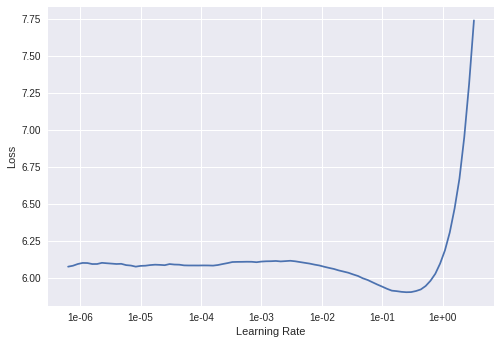

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,4.348042,4.182380,0.278534


In [0]:
# Not run because it takes a lot of time
learn.unfreeze()
learn.lr_find()
learn.fit_one_cycle(10)

In [0]:
learn.save_encoder('stage-1')  # Save only encoder part

## Create classifier

In [0]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=64))

data_clas.save('tmp-clas')

In [0]:
learn = text_classifier_learner(data_clas, drop_mult=0.5)
learn.load_encoder('stage-1')
learn.freeze()

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


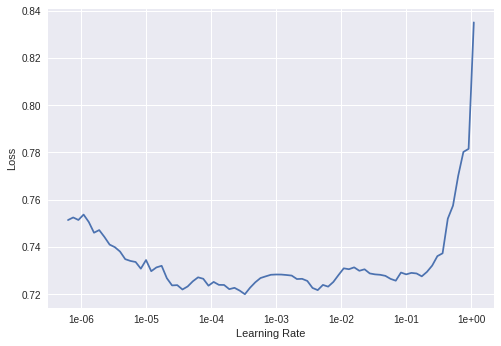

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, slice(1e-5 / (2.6 ** 4), 1e-5), moms=(0.8, 0.7))  # For text classifiers, it helps to decrease the momentum a little

epoch,train_loss,valid_loss,accuracy
1,0.719004,0.715259,0.500000


In [0]:
learn.save('first')

In [0]:
learn.freeze_to(-2)  # Unfreeze only last 2 layers: for text models, unfreeze one layer at a time

epoch,train_loss,valid_loss,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


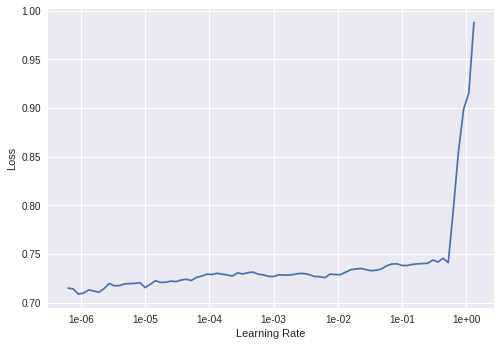

In [0]:
learn.lr_find()
learn.recorder.plot()

We will see the $x^4$ in the denominator at the end of the lesson. Why 2.6? So the difference between the first and the second parameters to `slice` is what's the rate at which the first layer learns and what's the rate at which the last layer learns, and this is called discriminative learning rates. 

So the question is as you go from layer to layer, how much do you decrease the learning rate by. For NLP RNNs, the answer turns out to be 2.6. How do you find that out? You run lots of different models using a lot of different hyperparameter settings, and create a random forest to predict how accurate the model would be based on the hyperparameters. And then you use random forest interpretation methods to figure out what the optimal parameter settings were.

In [0]:
learn.fit_one_cycle(1, slice(5e-4 / (2.6 ** 4), 5e-4), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy
1,0.691856,0.684095,0.571560


In [0]:
learn.save('second')

epoch,train_loss,valid_loss,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


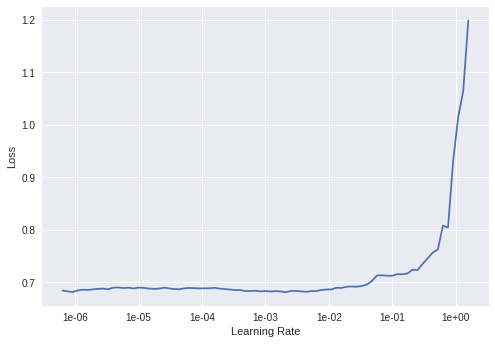

In [0]:
learn.freeze_to(-3)
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, slice(1e-3 / (2.6 ** 4), 1e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy
1,0.625524,0.597556,0.690120


In [0]:
learn.save('third')

In [0]:
learn.unfreeze()  # Unfreeze the whole thing

epoch,train_loss,valid_loss,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


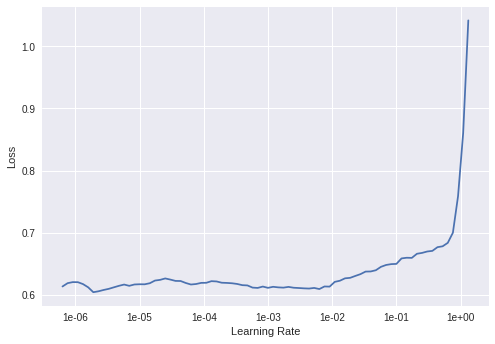

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(2, slice(1e-3 / (2.6 ** 4), 1e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy
1,0.500179,0.543274,0.707120
2,0.421202,0.373716,0.838560


In [0]:
learn.save('final-imdb')

In [0]:
!cp /root/.fastai/data/imdb/models/stage-1.pth gdrive/"My Drive"/fastai-v3/imdb-stage-1.pth

In [0]:
!cp /root/.fastai/data/imdb/models/final-imdb.pth gdrive/"My Drive"/fastai-v3/

In [49]:
learn.predict("I really loved that movie, it was awesome!")

(Category pos, tensor(1), tensor([0.4359, 0.5641]))

In [50]:
learn.predict("What garbage!")

(Category neg, tensor(0), tensor([0.7042, 0.2958]))

In [51]:
learn.predict("It was okay, nothing special.")

(Category neg, tensor(0), tensor([0.9441, 0.0559]))